# Part 1 – Carpet Detection (Signal Validation and Spectral Baseline)

## Objective

This notebook performs the initial physical validation of the vibration signals
before implementing any carpet detection logic.

The goal is to:

- Validate time axis consistency and sampling rate.
- Confirm usable bandwidth above 1000 Hz.
- Inspect global signal statistics (RMS, mean, variance).
- Establish a stable frequency-domain baseline using Welch PSD.

This step ensures that subsequent carpet detection is based on
physically consistent and spectrally reliable signals.


In [1]:
from pathlib import Path

import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt

from tractian_cm.io.loaders import load_part1_wave_csv



## 1. Dataset Overview

We begin by verifying that Part 1 CSV files are accessible
and correctly organized in the project structure.

Each file is expected to contain:
- `t`: time in seconds
- `data`: vibration signal (acceleration)


In [2]:
# Project-relative data directory (do not use absolute paths)
DATA_PART1 = Path("../data/part_1")

# List available CSV files (you should see your moved samples here)
files = sorted(DATA_PART1.glob("*.csv"))
len(files), [f.name for f in files[:5]]


(15,
 ['11d8b435-ba4a-564f-b0e8-d5cbed8adbb2.csv',
  '3186c48d-fc24-5300-910a-6d0bafdd87ea.csv',
  '555cbc73-5a58-53a2-b432-c415f46e8c7c.csv',
  '6dbf3276-3d5a-5c9f-930e-09da6ec60243.csv',
  '75a0970d-7c9a-5fd4-9a83-80cddf68ce6c.csv'])

## 2. Signal Summary and Sampling Characteristics

This section validates fundamental signal properties:

- Number of samples
- Signal duration
- Estimated sampling frequency (fs)
- Nyquist frequency
- Basic statistical metrics (mean, standard deviation, RMS)

These checks are critical because frequency-domain analysis
depends directly on correct sampling rate and time consistency.


In [3]:
def summarize_wave(path: Path):
    wave, fs = load_part1_wave_csv(path)
    t = np.array(wave.time, dtype=float)
    x = np.array(wave.signal, dtype=float)
    duration = t[-1] - t[0]
    nyquist = fs / 2.0
    return {
        "file": path.name,
        "n": len(x),
        "duration_s": duration,
        "fs_hz": fs,
        "nyquist_hz": nyquist,
        "x_mean": float(np.mean(x)),
        "x_std": float(np.std(x)),
        "x_rms": float(np.sqrt(np.mean(x**2))),
    }

summary_0 = summarize_wave(files[0])
summary_1 = summarize_wave(files[1]) if len(files) > 1 else None
summary_0, summary_1


({'file': '11d8b435-ba4a-564f-b0e8-d5cbed8adbb2.csv',
  'n': 32768,
  'duration_s': np.float64(2.068493150684932),
  'fs_hz': 15841.000000000451,
  'nyquist_hz': 7920.500000000226,
  'x_mean': -4.87890977618477e-19,
  'x_std': 0.45810611462435574,
  'x_rms': 0.45810611462435574},
 {'file': '3186c48d-fc24-5300-910a-6d0bafdd87ea.csv',
  'n': 32768,
  'duration_s': np.float64(2.024153694094391),
  'fs_hz': 16187.999999991345,
  'nyquist_hz': 8093.999999995673,
  'x_mean': -6.098637220230962e-20,
  'x_std': 0.16429986423103338,
  'x_rms': 0.16429986423103338})

### 2.1 Key Findings (from two samples)

- Estimated sampling rates are ~15.8–16.2 kHz, leading to Nyquist frequencies ~7.9–8.1 kHz.
  This confirms that the frequency band above 1000 Hz is fully observable in the dataset.
- Global signal energy differs substantially between samples (RMS ~0.46 vs ~0.16).
  Therefore, absolute thresholds in the spectrum are likely to be unreliable; a relative baseline
  (noise-floor) approach in dB is preferred for carpet detection.


## 3. Sampling Uniformity Validation

Frequency-domain methods such as FFT and Welch assume
uniform time sampling.

We verify:
- Median time step (Δt)
- Maximum relative deviation from median Δt

Low deviation confirms suitability for spectral estimation.


In [4]:
wave, fs = load_part1_wave_csv(files[0])
t = np.array(wave.time, dtype=float)

dt = np.diff(t)
dt_median = np.median(dt)
max_rel_dev = np.max(np.abs(dt - dt_median) / dt_median)

dt_median, max_rel_dev


(np.float64(6.312732782021158e-05), np.float64(1.4069634346470084e-11))

### 3.1 Key Findings (sampling uniformity)

- Median Δt is stable and the maximum relative deviation is ~1e-11, indicating virtually perfect
  uniform sampling.
- This supports the use of Welch PSD/FFT without resampling or interpolation, and reduces the risk
  of spectral artifacts unrelated to the physical phenomenon.


## 4. Time-Domain Inspection

We inspect a short segment of the waveform to:

- Verify amplitude scale
- Detect possible clipping or saturation
- Observe potential impulsive behavior

This visual inspection helps contextualize spectral observations.


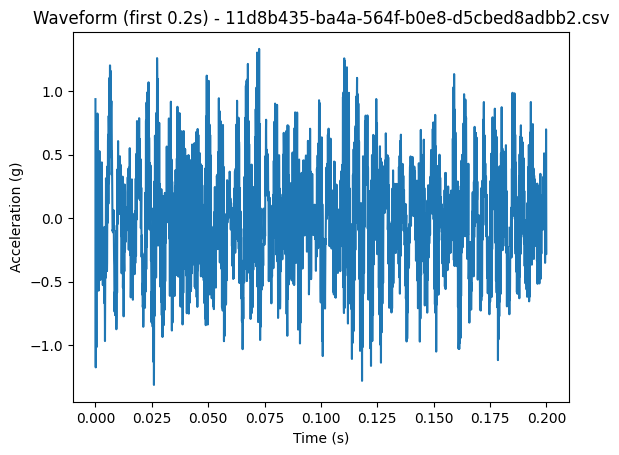

In [5]:
wave, fs = load_part1_wave_csv(files[0])
t = np.array(wave.time, dtype=float)
x = np.array(wave.signal, dtype=float)

# Plot only first 0.2 seconds (adjust if your signal is shorter)
t0 = t[0]
mask = (t - t0) <= 0.2

plt.figure()
plt.plot(t[mask] - t0, x[mask])
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (g)")
plt.title(f"Waveform (first 0.2s) - {files[0].name}")
plt.show()


## 5. Frequency-Domain Inspection (Welch PSD)

We estimate the Power Spectral Density (PSD) using Welch's method.

Why Welch:
- Reduces spectral variance compared to a single FFT
- Provides a stable baseline
- Suitable for detecting broadband energy (carpet)

We specifically verify:
- Frequency axis correctness
- Usable bandwidth above 1000 Hz
- Baseline behavior in high-frequency region


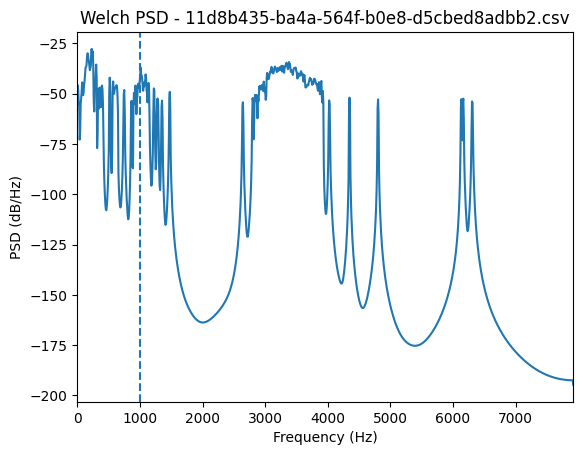

In [6]:
wave, fs = load_part1_wave_csv(files[0])
x = np.array(wave.signal, dtype=float)

# Welch parameters: start with conservative defaults; we will tune later
nperseg = 2048
noverlap = nperseg // 2

f, pxx = welch(x, fs=fs, nperseg=nperseg, noverlap=noverlap, window="hann", scaling="density")

# Convert to dB for interpretability (avoid log(0))
pxx_db = 10.0 * np.log10(pxx + 1e-20)

plt.figure()
plt.plot(f, pxx_db)
plt.axvline(1000, linestyle="--")
plt.xlim(0, fs / 2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (dB/Hz)")
plt.title(f"Welch PSD - {files[0].name}")
plt.show()


### 5.1 Preliminary Conclusions

From the initial validation:

- Sampling rates are consistent and sufficiently high.
- Nyquist frequency supports analysis above 1000 Hz.
- Signals are uniformly sampled.
- PSD provides stable baseline suitable for broadband detection.

The next step is to formalize a carpet detection strategy
based on noise-floor estimation in the frequency domain.
